# Aşama - 2

- Delta modülatör kurulacak --> Çıktısı 1 0 veya 1 -1 veya 1 0 -1 (parametric)
- 14 GHz Fs
- Modülatörün 1MHz snqr'ı 150 dB'den büyük olacak (?)
- Modülatörün kuantizasyon seviyeleri düzeltilecek

Input: Aşama - 1 Time domain output  
Output: Pulse bin dosyası - Pulse txt time dosyası

In [200]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 15,
    "figure.titlesize": 14,
    "lines.linewidth": 3,
    "lines.markersize": 8,
    "axes.grid": False,
    "axes.grid.which": "both",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.7,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": False,
    "ytick.right": False,
    "xtick.bottom": False,
    "ytick.left": False,
    "xtick.minor.visible": False,
    "ytick.minor.visible": False,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.linewidth": 1.2,
    "legend.frameon": True,
    "legend.framealpha": 0.8,
    "legend.fancybox": True,
    "legend.loc": "best",
    "font.size": 25,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cm"
})

In [201]:
# Import libraries
import numpy as np
import scipy as sp
from helpers import *
from constants import *

In [202]:
# Testing the modulator
Fs = 14e9
fin = 1e6 
t = np.arange(0, 10/fin, 1/Fs)
u = 1*np.sin(2*np.pi*fin*t)

#y01, _ = delta_sigma_cifb(u, mode="01")       # {0,1}
#ypm1, _ = delta_sigma_cifb(u, mode="pm1")     # {−1,1}
y3, _   = delta_sigma_cifb(u, mode="ternary") # {−1,0,1}

# Plot input and outputs
"""plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(u, label='Input')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(y01, label='Output (Quantized)', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(ypm1, label='Output (Quantized)', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(y3, label='Output (Quantized)', color='red')
plt.legend()
plt.tight_layout()
plt.show()"""

"plt.figure(figsize=(12, 8))\nplt.subplot(4, 1, 1)\nplt.plot(u, label='Input')\nplt.legend()\nplt.subplot(4, 1, 2)\nplt.plot(y01, label='Output (Quantized)', color='orange')\nplt.legend()\nplt.subplot(4, 1, 3)\nplt.plot(ypm1, label='Output (Quantized)', color='green')\nplt.legend()\nplt.subplot(4, 1, 4)\nplt.plot(y3, label='Output (Quantized)', color='red')\nplt.legend()\nplt.tight_layout()\nplt.show()"

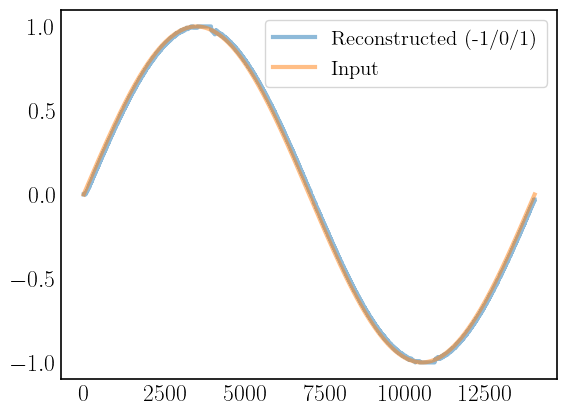

In [213]:
#ypm1_lp = moving_average(ypm1)
y3_lp = moving_average(y3)
#plt.plot(ypm1_lp, alpha=0.5, label="Reconstructed (-1/1)")
plt.plot(y3_lp[:int(1/fin * Fs)], alpha=0.5, label="Reconstructed (-1/0/1)")
plt.plot(u[:int(1/fin * Fs)], alpha=0.5, label="Input")
plt.legend()
plt.show()

C:\Users\Kerem\AppData\Local\Temp\ipykernel_21128\1672668047.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f[f<2e9]*1e-9, 10*np.log10(Pxx_den[f<2e9]))


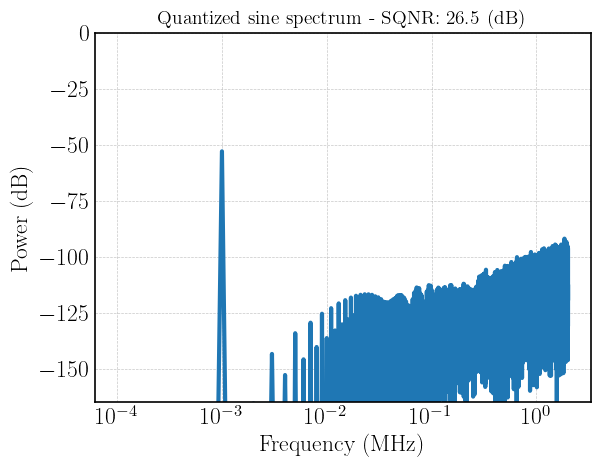

In [215]:
f, Pxx_den = sp.signal.periodogram(y3, 14e9)
P_total = np.sum(Pxx_den[f<1e9+1])
P_noise = np.sum(Pxx_den[f<1e9+1]) - np.max(Pxx_den[f<1e9+1])
SQNR = 10*np.log10(np.max(Pxx_den[f<1e9+1])/P_noise)
plt.semilogx(f[f<2e9]*1e-9, 10*np.log10(Pxx_den[f<2e9]))
plt.ylim([-165,1e-7])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Power (dB)")
plt.title(f"Quantized sine spectrum - SQNR: {SQNR:.1f} (dB)")
plt.grid(True)
plt.show()

In [224]:
Fs = 14e9
fin = 1e2 ; 
t = np.arange(0, 5/fin, 1/Fs)
u = np.zeros_like(t)
u = 1*np.sin(2*np.pi*fin*t)
y3 = np.zeros_like(u)
y3, _ = delta_sigma_cifb(u, mode="ternary")
q = np.diff(u, prepend=0) - np.diff(y3, prepend=0)

# SQNR calculation
signal_power = np.mean(np.diff(u)**2)
noise_power = np.mean(q**2)
sqnr = 10 * np.log10(signal_power / noise_power)
print("SQNR (dB):", sqnr)

KeyboardInterrupt: 

Estimated SQNR: 5.62 dB


C:\Users\Kerem\AppData\Local\Temp\ipykernel_21128\1706827554.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(freqs, 10*np.log10(PSD))


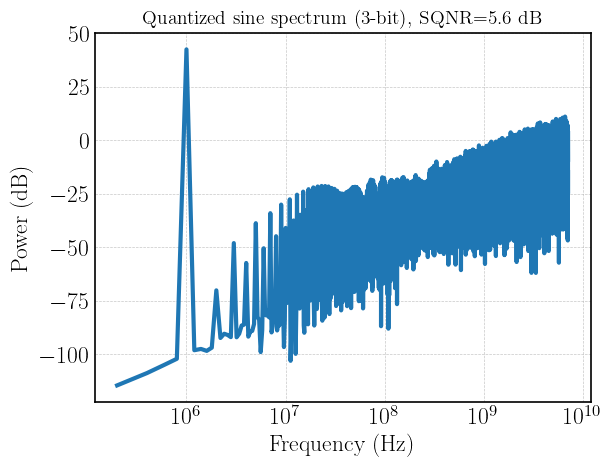

In [80]:
# --- FFT & SQNR (no window) ---
U = np.fft.rfft(y3)
freqs = np.fft.rfftfreq(len(t), 1/Fs)
PSD = np.abs(U)**2 / len(t)  # power spectrum

# Find tone bin
tone_bin = np.argmin(np.abs(freqs - fin))
sig_bins = np.arange(tone_bin-1, tone_bin+2)  # sum 3 bins around tone
P_signal = PSD[sig_bins].sum()
P_total = PSD.sum()
P_noise = P_total - P_signal
SQNR_dB = 10*np.log10(P_signal / P_noise)

print(f"Estimated SQNR: {SQNR_dB:.2f} dB")

# --- Plot spectrum ---
plt.figure()
plt.semilogx(freqs, 10*np.log10(PSD))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.title(f"Quantized sine spectrum ({3}-bit), SQNR={SQNR_dB:.1f} dB")
plt.grid(True)
plt.show()

In [15]:
# Read measurement data from file
filename = "tones_fs100.000MHz_sp100dB.txt" # CHANGE PATH ACCORDINGLY

# If your file has a header line, add: skiprows=1
tone, amp, phase = np.loadtxt(
    filename,
    delimiter=" ",
    converters={0: to_float, 1: to_float},
    unpack=True,          # gives t, u directly (no .T needed)
    encoding="utf-8"      # ensures numpy hands us str (but we handle both)
)

tone, amp, phase = np.asarray(tone, dtype=float), np.asarray(amp, dtype=float), np.asarray(phase, dtype=float)

tlist = np.arange(0, 0.00822, 1/14e9)
signal = cosine_sum_on_ref_grid(np.array([[tone[i], amp[i], phase[i]] for i in range(len(tone))]), len(signal1))

print("First 10 time samples:", tlist[:10])
print("Sampling frequency:", fmt_fs(1/14e9))
print("First 10 amplitude samples:", signal[:10])
print("Time length:", len(tlist))
print("Signal length:", len(signal))

First 10 time samples: [0.00000000e+00 7.14285714e-11 1.42857143e-10 2.14285714e-10
 2.85714286e-10 3.57142857e-10 4.28571429e-10 5.00000000e-10
 5.71428571e-10 6.42857143e-10]
Sampling frequency: 14000000000.0
First 10 amplitude samples: [3765.06064362 3765.06106973 3765.06149585 3765.06192196 3765.06234808
 3765.0627742  3765.06320031 3765.06362643 3765.06405255 3765.06447866]
Signal1 length: 115080000
Signal2 length: 115080000
float64


In [55]:
signal_modulated , _ = delta_sigma_cifb(signal, mode="ternary")

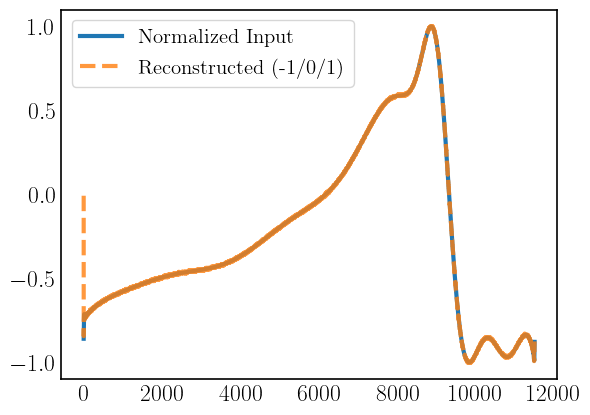

In [56]:
signal_modulated_lp = np.zeros_like(signal_modulated)
signal_modulated_lp = moving_average(signal_modulated)
plt.plot(2.0 * (signal[::10000] - np.min(signal[::10000])) / (np.max(signal[::10000]) - np.min(signal[::10000])) - 1.0, label="Normalized Input")
plt.plot(signal_modulated_lp[::10000], "--", alpha=0.8, label="Reconstructed (-1/0/1)")
plt.legend()
plt.show()

In [20]:
with open("modulation.txt", "w") as f:  
    for i in range(len(signal_modulated)):
        f.write(f"{int(signal_modulated[i])}\n")

# Aşama - 3

- Alınan pulse txt sinyali dosyası, katsayı ile yükseltilecek : h/2e * FJaws (14 GHz) * N_eklem(4000)
- Bu sinyalin FTsi alınacak
- Tekrar bir tone listesi çıkarılacak

Input : Aşama - 2 txt dosyası  
Output : Jaws çıkışı Tone listesi

In [21]:
# Constant for part JAWS
FJaws = 14e9
h = sp.constants.h   # Planck's constant in J·s
e = sp.constants.e   # electron charge in C
N_eklem = 4000

jaws_gain = h * FJaws * N_eklem / (2 * e)
print(jaws_gain)

jaws_signal = jaws_gain * signal

0.11579869551386805


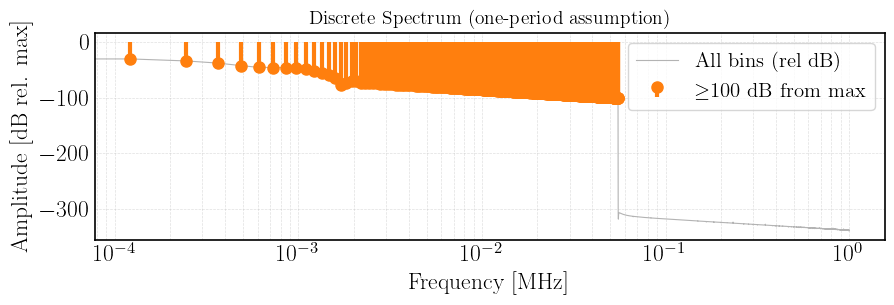

Saved tones to jaws_tones_14g.txt


In [23]:
tones, spec = period_spectrum_select_tones(
     jaws_signal, 14e9,
     db_floor_db=100,
     freq_max=1e6+1,
     plot_time=False,
     plot_spectrum=True,
     save_txt=True,
     txt_name="jaws_tones_14g.txt",
 )


In [24]:
# ---- Step 1: Replace -1 with 2
signal_modulated[signal_modulated == -1] = 2

# ---- Step 2: Prepare
L = len(signal_modulated)
K = L // 4
Byte = np.zeros(K, dtype=np.uint8)

# ---- Step 3: Pack 4 symbols into 1 byte
for k in tqdm(range(K)):
    Byte[k] = (signal_modulated[k*4 + 3] * 32 +
               signal_modulated[k*4 + 2] * 16 +
               signal_modulated[k*4 + 1] * 4  +
               signal_modulated[k*4 + 0] * 1)

# ---- Step 4: Create filename
with open("pulses_binary.bin", "wb") as f:
    f.write(Byte.tobytes())


100%|██████████| 28770000/28770000 [00:50<00:00, 564513.37it/s]


# Aşama - 4

- Hazır transfer fonskiyonu Jaws çıktısındaki tonlar için hesaplanacak, ayrıca düzeltilmiş sinyalin ton listesi hazırlanacak

Input: Jaws çıkışı Tone listesi  
Output: Transfer fonksiyonu ve transfer fonksiyonu tone listesi

Gain at 0 Hz = 0.9999999968058151
Gain at 1 Hz = 0.9999999968058212
Gain at 1 KHz = 1.0000000029596743
Gain at 1 MHz = 1.0061885306525291


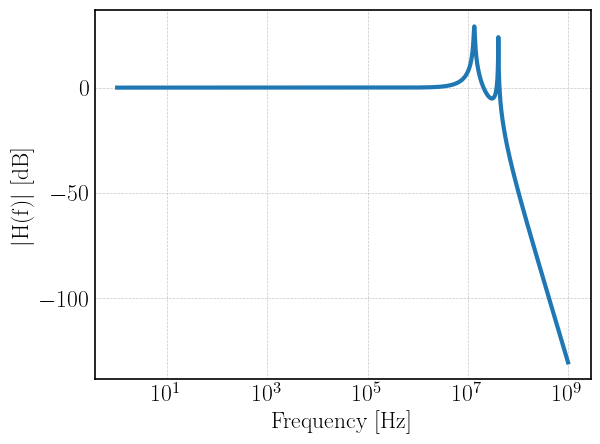

In [52]:
p = dict(
    R_N=1e9,                 # Ohm
    C_N=40e-12,              # F

    C_p_cable=60e-12,        # F
    R_s_cable=0.185,         # Ohm
    R_p_cable=1e12,          # Ohm
    L_s_cable=0.6e-6,        # H

    C_p_probe=60e-12,        # F
    R_p_probe=500e9,         # Ohm
    R_s_probe=3,             # Ohm
    L_s_probe=0.6e-6         # H
)

# Single frequency example
print("Gain at 0 Hz =", abs(H(0, p)[0]))
print("Gain at 1 Hz =", abs(H(1, p)[0]))
print("Gain at 1 KHz =", abs(H(1e3, p)[0]))
print("Gain at 1 MHz =", abs(H(1e6, p)[0]))

# Frequency sweep example
f = np.logspace(0, 9, 1000000)   # 1 Hz to 1 MHz
Hf = H(f, p)

plt.figure()
plt.semilogx(f, 20*np.log10(np.abs(Hf)))
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$|$H(f)$|$ [dB]")
plt.grid(True, which="both")
plt.show()

In [225]:
transmit_line_adjusted = np.zeros_like(tones)

# Calculate and print gain for each tone
for i in range(len(tones[0])):
    tone, amp, phase0 = tones[0][i], tones[1][i], tones[2][i]
    transmit_line_adjusted[0][i] = tone
    
    gain = abs(H(tone, p)[0])
    print(f"Gain at {tone} Hz = {gain:.6f} ({20*np.log10(gain):.2f} dB)")
    transmit_line_adjusted[1][i] = gain * amp

    phase = np.angle(H(tone,p)[0])
    print(f"Phase at {tone} Hz = {phase:.6f}")
    transmit_line_adjusted[2][i] = phase0 + phase

np.savetxt("transmit_line_tones.txt", tones, fmt="%.12g", header="freq_Hz amplitude phase_rad")

Gain at 0.0 Hz = 1.000000 (-0.00 dB)
Phase at 0.0 Hz = 0.000000
Gain at 452.0077538951827 Hz = 1.000000 (-0.00 dB)
Phase at 452.0077538951827 Hz = -0.000001
Gain at 0.0 Hz = 1.000000 (-0.00 dB)
Phase at 0.0 Hz = 0.000000


Save to a file